# Approach 1
This pipeline pre-process the image, applying a series of filters with openCV and then tries to find the license plate. It will need to be adapted to get the location of the license plate rather than exctracting the ROI from the original image. The [blog post](https://www.pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/) also continues the pipeline by applying OCR to the license plate and extracting the letters and numbers. 

In [1]:
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [2]:
class PyImageSearchANPR:
    def __init__(self, minAR=2, maxAR=5, debug=False):
        # store the minimum and maximum rectangular aspect ratio
        # values along with whether or not we are in debug mode
        self.minAR = minAR
        self.maxAR = maxAR
        self.debug = debug
    

    def debug_imshow(self, title, image, waitKey=False):
        # check to see if we are in debug mode, and if so, show the
        # image with the supplied title
        if self.debug:
            cv2.imshow(title, image)
            # check to see if we should wait for a keypress
            if waitKey:
                cv2.waitKey(0)


    def locate_license_plate_candidates(self, gray, keep=5):
        # perform a blackhat morphological operation that will allow
        # us to reveal dark regions (i.e., text) on light backgrounds
        # (i.e., the license plate itself)
        rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
        self.debug_imshow("Blackhat", blackhat)

        # next, find regions in the image that are light
        squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
        light = cv2.threshold(light, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.debug_imshow("Light Regions", light)

        # compute the Scharr gradient representation of the blackhat
        # image in the x-direction and then scale the result back to
        # the range [0, 255]
        gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
		    dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
        gradX = gradX.astype("uint8")
        self.debug_imshow("Scharr", gradX)

		# blur the gradient representation, applying a closing
		# operation, and threshold the image using Otsu's method
        gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
        thresh = cv2.threshold(gradX, 0, 255,
        	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.debug_imshow("Grad Thresh", thresh)

        # perform a series of erosions and dilations to clean up the
        # thresholded image
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        self.debug_imshow("Grad Erode/Dilate", thresh)

        # take the bitwise AND between the threshold result and the
        # light regions of the image
        thresh = cv2.bitwise_and(thresh, thresh, mask=light)
        thresh = cv2.dilate(thresh, None, iterations=2)
        thresh = cv2.erode(thresh, None, iterations=1)
        self.debug_imshow("Final", thresh, waitKey=True)

        # find contours in the thresholded image and sort them by
        # their size in descending order, keeping only the largest
        # ones
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        	cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]
        # return the list of contours
        return cnts


    def locate_license_plate(self, gray, candidates,
        clearBorder=False):
        # initialize the license plate contour and ROI
        lpCnt = None
        roi = None
        # loop over the license plate candidate contours
        for c in candidates:
            # compute the bounding box of the contour and then use
            # the bounding box to derive the aspect ratio
            (x, y, w, h) = cv2.boundingRect(c)
            ar = w / float(h)

            # check to see if the aspect ratio is rectangular
            if ar >= self.minAR and ar <= self.maxAR:
                # store the license plate contour and extract the
                # license plate from the grayscale image and then
                # threshold it
                lpCnt = c
                licensePlate = gray[y:y + h, x:x + w]
                roi = cv2.threshold(licensePlate, 0, 255,
                	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

                # check to see if we should clear any foreground
                # pixels touching the border of the image
                # (which typically, not but always, indicates noise)
                if clearBorder:
                	roi = clear_border(roi)
                # display any debugging information and then break
                # from the loop early since we have found the license
                # plate region
                self.debug_imshow("License Plate", licensePlate)
                self.debug_imshow("ROI", roi, waitKey=True)
                break
		# return a 2-tuple of the license plate ROI and the contour
		# associated with it
        return (roi, lpCnt, (x,y,w,h))

In [4]:
image = cv2.imread("./database/train/images/Cars1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
clearBorder = False
anpr = PyImageSearchANPR(debug=False)
# convert the input image to grayscale, locate all candidate
# license plate regions in the image, and then process the
# candidates, leaving us with the *actual* license plate
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
candidates = anpr.locate_license_plate_candidates(gray)
(lp, lpCnt, (x,y,w,h)) = anpr.locate_license_plate(gray, candidates,
	clearBorder=clearBorder)

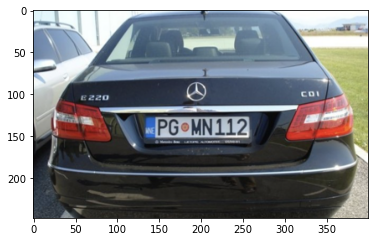

In [5]:
plt.imshow(image)

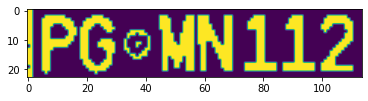

In [6]:
plt.imshow(lp)

In [7]:
(x,y,w,h)

(144, 128, 114, 23)

In [8]:
# lpCnt
cv2.boundingRect(lpCnt[0])

(189, 128, 1, 1)